In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sts

from sqlalchemy import create_engine

plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2.2
%matplotlib inline

In [3]:
# Set db variables
user = 'anthony'
pw = 'pw'
host = 'localhost:5432'
db_name = 'indicator_tests'

# Create engine for interacting with db
engine = create_engine(f'postgresql+psycopg2://{user}:{pw}@{host}/{db_name}')

### Get NASDAQ ETF list :
nas_etf = pd.read_csv('data/NAS_ETF_List.csv')
nas_etf = nas_etf['Symbol'].to_list()

### SMA Entries
sma_nas = pd.read_sql_query(f'''SELECT ticker, sma_win
                                FROM sma_nasdaq
                                WHERE sma_buy = 1''',
                            con=engine)

sma_nas.dropna(inplace=True)

# Remove ETFs if exist
sma_nas = sma_nas[~sma_nas.ticker.isin(nas_etf)]

### Random Entries
rnd_nas = pd.read_sql_query(f'''SELECT ticker, rnd_win
                                FROM sma_nasdaq
                                WHERE rnd_buy = 1''',
                            con=engine)

# Remove ETFs if exist
rnd_nas = rnd_nas[~rnd_nas.ticker.isin(nas_etf)]

## Statisitcs

In [4]:
rnd_data = rnd_nas.rnd_win
sma_data = sma_nas.sma_win

t_stat, p_value = sts.ttest_ind(rnd_data, sma_data, equal_var=False)

print(f't_stat: {t_stat}\np_value: {p_value}')

t_stat: -0.543584428915917
p_value: 0.5867480026815965


In [5]:
def compute_power(null, alt, alpha):
    mu0 = null.mean()
    se0 = null.std() / np.sqrt(len(null))
    
    mua = alt.mean()
    sea = alt.std() / np.sqrt(len(alt))
    
    h0 = sts.norm(mu0, se0)
    ha = sts.norm(mua, sea)
    
    critical_value = h0.ppf(1 - alpha)
    power = 1 - ha.cdf(critical_value)
    
    return power

In [6]:
power = compute_power(rnd_data, sma_data, 0.05)

print(f'Test power: {power}')

Test power: 0.19011899503025287


In [7]:
def standard_deviation_difference_in_proportions(n1, p1, n2, p2):
    p = (n1*p1 + n2*p2) / (n1 + n2)
    return np.sqrt(p*(1-p))

In [8]:
def calc_minimum_sample_size(control_data, treatment_data, alpha, effect_size, power):
    """Calculate the minimum sample size for a z-test needed to achieve a given power.
    
    Parameters
    ----------
    
    control_data: array
      One dimensional array containing data from control group.
    
    treatment_data: array
      One dimensional array containing data from treatment group.
    
    alpha: float
      Desired significance level.  Must be between zero and one.
    
    effect_size: float
      Desired effect size to detect.
    
    power: float
      Desired power.  Must be between zero and one.
    
    Returns
    -------
    
    sample_size: int
      Minimum sample size to achieve a desired power.
    """
    standard_normal = sts.norm(0, 1)
    beta = 1 - power
    
    mu0 = control_data.mean()
    mua = treatment_data.mean()
    sigma = standard_deviation_difference_in_proportions(
        len(control_data), mu0, len(treatment_data), mua)
    
    numerator = sigma * (standard_normal.ppf(1 - alpha) - standard_normal.ppf(beta))
    denominator = mua - mu0
    return math.ceil((numerator / denominator) ** 2)

In [11]:
mu_diff = abs(rnd_data.mean()-sma_data.mean())
power = 0.95
alpha = 0.05

minsize = calc_minimum_sample_size(rnd_data, sma_data, alpha, mu_diff, power)

print(f'Minimum sample size needed to achieve:\n{power} power\n{mu_diff:.3f} effect size\n{alpha} alpha\nis {minsize} samples')

Minimum sample size needed to achieve:
0.95 power
0.006 effect size
0.05 alpha
is 54064 samples


## Plots

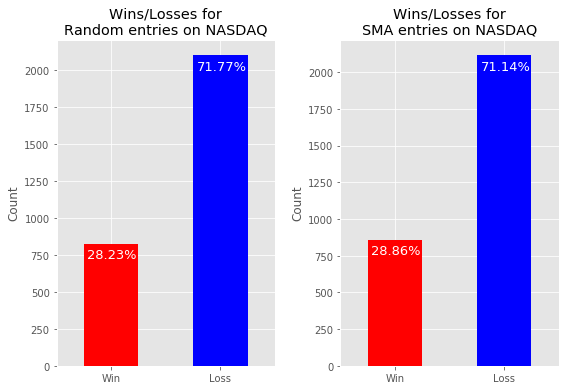

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10,20))

axs[1] = sma_nas.sma_win.value_counts().plot(kind='bar',
                                         figsize=(9,6),
                                         title= 'Wins/Losses for\nSMA entries on NASDAQ',
                                         color=['blue', 'red'],
                                         ax=axs[1]
                                        )

axs[0] = rnd_nas.rnd_win.value_counts().plot(kind='bar',
                                         figsize=(9,6),
                                         title= 'Wins/Losses for\nRandom entries on NASDAQ',
                                         color=['blue', 'red'],
                                         ax=axs[0]
                                        )

for ax in axs: 
    ax.set_xticklabels(['Loss', 'Win'])
    ax.invert_xaxis()
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', labelrotation=0)
    
    totals = []
    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_height())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+.468, i.get_height()-100, \
                str(round((i.get_height()/total)*100, 2))+'%', fontsize=13,
                    color='white')

plt.subplots_adjust(wspace = 0.3)
# plt.savefig('../images/winloss.png')        

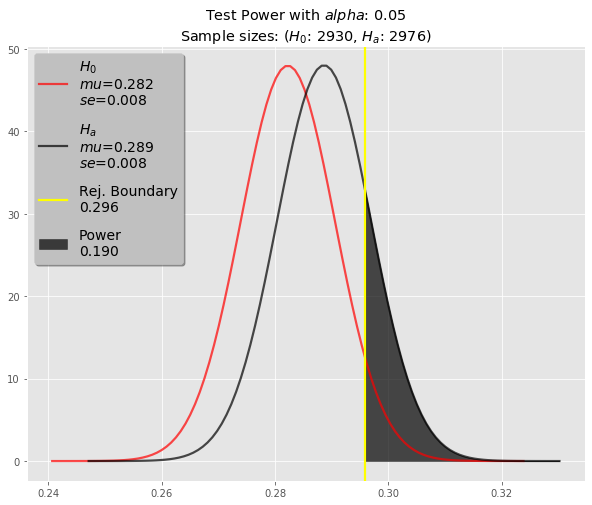

In [13]:
# Pull everything out of function so plt.savefig will work
rnd_data = rnd_nas.rnd_win
sma_data = sma_nas.sma_win

H0 =rnd_data
HA =sma_data
alpha=.05
one_tailed=True
figsize=(10,8)
force_n=None

#####

fig, ax = plt.subplots(1,1, figsize=figsize)

df = len(H0)-1
crit_val = sts.t.ppf(1-alpha, df) if one_tailed==True else sts.t.ppf(1-alpha/2, df)

if force_n:
    n0 = force_n
    nA = force_n
else:
    n0 = len(H0)
    nA = len(HA)


# Curve 1
mu0 = H0.mean()
std0 = H0.std()
sigma0 = std0/np.sqrt(n0)
x = np.linspace(mu0 - 5 * sigma0, mu0 + 5 * sigma0, 100)
label1 = f"$H_0$\n$mu$={mu0:.3f}\n$se$={sigma0:.3f}"
ax.plot(x, sts.norm.pdf(x, mu0, sigma0), color="red", alpha=0.7, label=label1)

# Curve 2
muA = HA.mean()
stdA = HA.std()
sigmaA = stdA/np.sqrt(nA)
x = np.linspace(muA - 5 * sigmaA, muA + 5 * sigmaA, 100)
label2 = f"$H_a$\n$mu$={muA:.3f}\n$se$={sigmaA:.3f}"
ax.plot(x, sts.norm.pdf(x, muA, sigmaA), color="black", alpha=0.7, label=label2)


# Critical line
crit_line = (mu0 + crit_val * sigma0)
ax.axvline(crit_line, color='yellow', label=f"Rej. Boundary\n{crit_line:.3f}")

# Power region
x3 = np.linspace(crit_line, muA + 5 * sigmaA, 100)
power = 1 - sts.norm(muA, sigmaA).cdf(crit_line)
ax.fill_between(x3, sts.norm.pdf(x3, muA, sigmaA), color='black', alpha=0.7, label=f"Power\n{power:.3f}")


ax.set_title(f'''Test Power with $alpha$: {alpha}
Sample sizes: ($H_0$: {n0}, $H_a$: {nA})''')

ax.legend(loc='upper left', fontsize=14, shadow=True, 
          facecolor='silver', labelspacing=1)


# plt.savefig('../images/testpower.png')

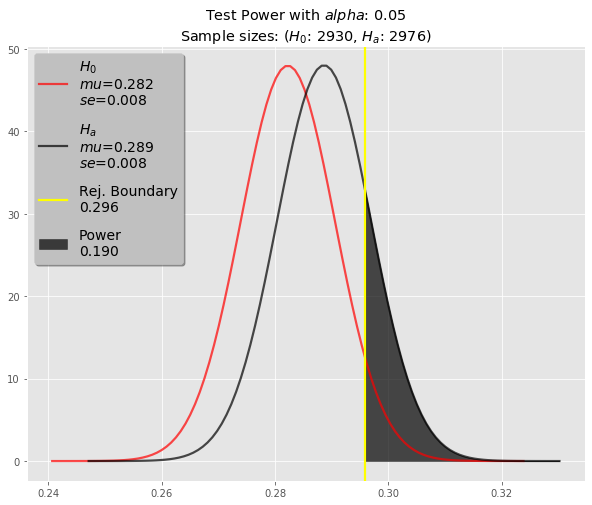

In [14]:
# Pull everything out of function so plt.savefig will work
rnd_data = rnd_nas.rnd_win
sma_data = sma_nas.sma_win

H0 =rnd_data
HA =sma_data
alpha=.05
one_tailed=True
figsize=(10,8)
force_n=None

#####

fig, ax = plt.subplots(1,1, figsize=figsize)

df = len(H0)-1
crit_val = sts.t.ppf(1-alpha, df) if one_tailed==True else sts.t.ppf(1-alpha/2, df)

if force_n:
    n0 = force_n
    nA = force_n
else:
    n0 = len(H0)
    nA = len(HA)


# Curve 1
mu0 = H0.mean()
std0 = H0.std()
sigma0 = std0/np.sqrt(n0)
x = np.linspace(mu0 - 5 * sigma0, mu0 + 5 * sigma0, 100)
label1 = f"$H_0$\n$mu$={mu0:.3f}\n$se$={sigma0:.3f}"
ax.plot(x, sts.norm.pdf(x, mu0, sigma0), color="red", alpha=0.7, label=label1)

# Curve 2
muA = HA.mean()
stdA = HA.std()
sigmaA = stdA/np.sqrt(nA)
x = np.linspace(muA - 5 * sigmaA, muA + 5 * sigmaA, 100)
label2 = f"$H_a$\n$mu$={muA:.3f}\n$se$={sigmaA:.3f}"
ax.plot(x, sts.norm.pdf(x, muA, sigmaA), color="black", alpha=0.7, label=label2)


# Critical line
crit_line = (mu0 + crit_val * sigma0)
ax.axvline(crit_line, color='yellow', label=f"Rej. Boundary\n{crit_line:.3f}")

# Power region
x3 = np.linspace(crit_line, muA + 5 * sigmaA, 100)
power = 1 - sts.norm(muA, sigmaA).cdf(crit_line)
ax.fill_between(x3, sts.norm.pdf(x3, muA, sigmaA), color='black', alpha=0.7, label=f"Power\n{power:.3f}")


ax.set_title(f'''Test Power with $alpha$: {alpha}
Sample sizes: ($H_0$: {n0}, $H_a$: {nA})''')

ax.legend(loc='upper left', fontsize=14, shadow=True, 
          facecolor='silver', labelspacing=1)


# plt.savefig('../images/testpower.png')